# Supervised learning assignment
My supervised learning assignment.

Author: <b>Rients Dalstra</b>
<br> <br>
I have put all my functions in the file supervised_functions.ipynb which I run below.

In [1]:
%run Supervised_functions.ipynb

# Parkinson data
Obtained from:
```
'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection',
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. 
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)
```

### Introduction
Witin this notebook I will train several models and evluate their performance based on how well they can predict if a subject has parkinsons or not. <br>
To do this will perform several steps: <br>
1. <b> Inspect the data. </b> <br>
    I will figure out what the balance of the classes are. And I will see if some of the features have multicollinearity. 
2. <b> Perform feature selection </b> <br>
    I will figure out which features I should use for developing the model.
3. <b> Model selection </b> <br>
    Here I select the models that I will train and compare against each other.
4. <b> Hyperparameter tuning </b> <br>
    Here i will tune the hyper parameters of the selected models.
5. <b> Model evaluation </b> <br>
    Here i apply the best parameters to the model and evaluate their performace
6. <b> Results </b> <br>
    At the end I give a short conclusion regarding the results of the models and the data

## 1. Inspecting the data

In [2]:
# Loading in the dataset
df = pd.read_csv('parkinsons.data')
df['status'].count()

195

### Checking how balanced the dataset is

In [3]:
# Splitting the data into two classes
df1 = df[df['status'] == 1 ]
df0 = df[df['status'] == 0 ]
print(" Samples with parkinson: " ,df1['status'].count(),'\n',"Samples without parkinson: ",df0['status'].count())

 Samples with parkinson:  147 
 Samples without parkinson:  48


The dataset is not entirely balanced, and there is about a 3/4 vs a 1/4 split. However I do not believe this will affect the model to much and i will not up or down sample the data. <br> I will just pay more attention to the confusion matrix metrics than accuracy.

### Creating heatmap using the robert pearson correlation test from python pandas

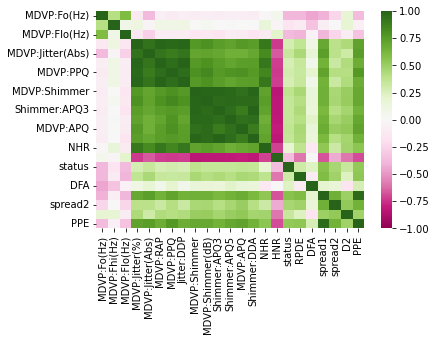

In [4]:
# Creating a correlation heatmap
df_corr = df.corr()
sns.heatmap(df_corr, cmap="PiYG", vmin=-1, vmax=1)
plt.show()

The correlation heatmap shows that there are a lot of correlations between the features themselves. <br>
This makes sense as a lot of the features describe the same thing but just in different ways or over different amplitudes. 

For example according to the research paper the columns MDVP:Shimmer and MDVP:Shimmer(dB) contain the same information. <br>
The same goes for MDVP:Jitter(%) and MDVP:Jitter(Abs).

The parkinsons.names file contains information about the columns and already groups them. <br>
To make sure that the columns are correlated I have applied the previously used robert pearson correlation test on the grouped features plus the status and presented them below.
This shows nothing new compared to the heatmap above but it makes everything clearer.


### Grouped heatmaps

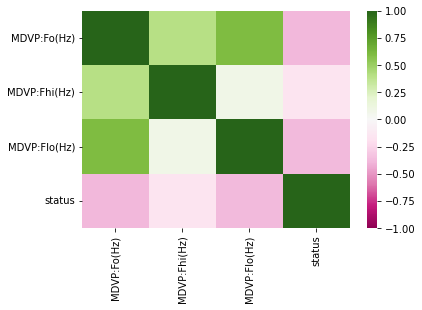

In [5]:
# The parkinson.names file did not group them and for good reason as they are not heavily correlated with each other.
df_freq = df[['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)','status']]
sns.heatmap(df_freq.corr(), cmap="PiYG", vmin=-1, vmax=1)
plt.show()

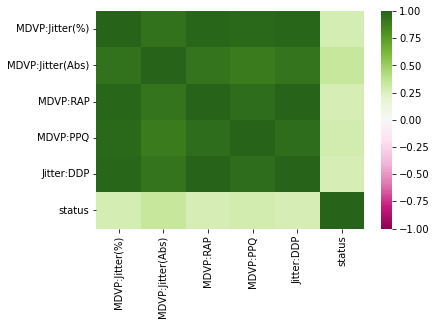

In [6]:
# the Several measures of variation in fundamental frequency show a very strong correlation among each other.
df_mdvp = df[['MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP','status']]
sns.heatmap(df_mdvp.corr(), cmap="PiYG", vmin=-1, vmax=1)
plt.show()

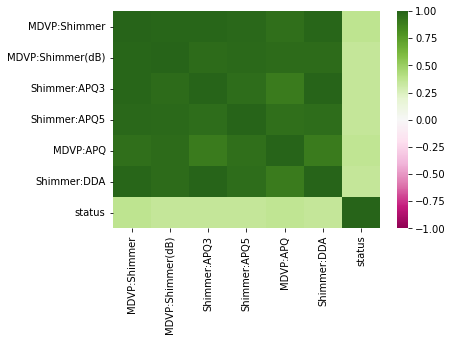

In [7]:
# the Several measures of variation in amplitude also show a very strong correlation among each other.
df_shim = df[['MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA','status']]
sns.heatmap(df_shim.corr(), cmap="PiYG", vmin=-1, vmax=1)
plt.show()

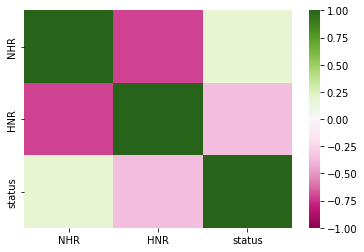

In [8]:
# To no suprise the noise to harmonics ratio and harmonics to noise ratio are completly inverse to each other.
df_R = df[['NHR','HNR','status']]
sns.heatmap(df_R.corr(), cmap="PiYG", vmin=-1, vmax=1)
plt.show()

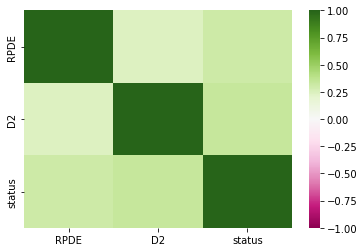

In [9]:
# While these are grouped there seems to be no strong correlation between them.
df_R2 = df[['RPDE','D2','status']]
sns.heatmap(df_R2.corr(), cmap="PiYG", vmin=-1, vmax=1)
plt.show()

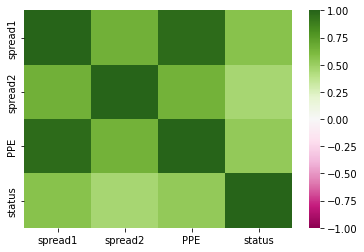

In [10]:
# Spread1 and PPE seem to have a very high correlation
df_spread = df[['spread1','spread2','PPE','status']]
sns.heatmap(df_spread.corr(), cmap="PiYG", vmin=-1, vmax=1)
plt.show()

#### Correlation results
I now have identified 4 groups  with mutliple features that have a high (above 0.80) or even perfect (1) correlation with each other.

* 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP'

* 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5','MDVP:APQ', 'Shimmer:DDA'

* 'NHR','HNR'

* spread1, 'PPE

Because of the correlation within each group I can reduce each group down to a single feature to improve the performance of the model. <br>
For the NHR/HNR group with a perfect correlation I can simply pick one of them and it will make zero difference.

To find out the most impactfull feature of the other groups, I will construct a simple decision tree classifier with default parameters and only train it on the features within a single group.
I will then run permutation importance on the model to see which feature is best suited to lead its group.

## 2. Feature selection
Using permutation importance to figure out the best features
> Permutation importance: This method will randomly shuffle the data of 1 feature and therefor breaking the relation that this feature has with the target. It will then evaluate how well the model performs without the relation of this feature. If a model performs the same it means that feature has a low impact and it will then get a low permutation score. However since permuation importance evaluates how the feature impacts the model it is important that the model performs well. <br> Source: https://scikit-learn.org/stable/modules/permutation_importance.html

In [11]:
# Creating the decision tree classifier. Because for now i only use it to check for the best features, i did not do any parameter tuning. 
# I have chosen a decision tree classifier for this because it is a robust model that does not need a lot of tuning/work/data to perform decently and decently is all i need for now.
# This model will also serve as a benchmark for other models i will create later on.
def dct_model():
    params = {}
    model = DecisionTreeClassifier()
    return model, params

In [12]:
# Creating 3 different groups of features to obtain 3 single features.
X1 = df[['MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP']]
X2 = df[['MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5','MDVP:APQ', 'Shimmer:DDA']]
X3 = df[['spread1', 'PPE']]
y = df['status']
X_list = [X1,X2,X3]
k = 0
for X in X_list:
    k = k + 1
    permutation_importance(X, y, dct_model())
    # Making sure to check the accuracy metrics of the model to see if it makes sense to perform permutation importance.
    accuracy_scores_dct(X, y, str(k))
    


Weight,Feature
0.3628 ± 0.0377,MDVP:Jitter(Abs)
0.2897 ± 0.0366,MDVP:RAP
0.1282 ± 0.0215,MDVP:Jitter(%)
0.1218 ± 0.0314,Jitter:DDP
0.0321 ± 0.0162,MDVP:PPQ


,X1
Accuracy,0.846154
F1,0.909091
Precision,0.882353
Recall,0.937500


Weight,Feature
0.4769 ± 0.0359,MDVP:APQ
0.1295 ± 0.0348,Shimmer:APQ5
0.0795 ± 0.0174,Shimmer:APQ3
0.0551 ± 0.0192,Shimmer:DDA
0.0474 ± 0.0208,MDVP:Shimmer(dB)
0.0103 ± 0.0103,MDVP:Shimmer


,X2
Accuracy,0.820513
F1,0.888889
Precision,0.903226
Recall,0.875000


Weight,Feature
0.3372 ± 0.0463,PPE
0.1654 ± 0.0096,spread1


,X3
Accuracy,0.871795
F1,0.925373
Precision,0.885714
Recall,0.968750


Based on the results of the feature importance the best features for the 3 groups are:
1. MDVP:Jitter(Abs) (The permuation importance on can present any of the features in the group as the best)
2. MDVP:APQ
3. PPE
4. NHR (random pick)

The most suprising part is that the decision tree classifier is already very accurate even when only using two features and default parameters

## 3. Model selection
Now that all the features have been selected a suitable model can be picked.

In [13]:
# applying the features to x and y
X = df[['MDVP:Jitter(Abs)','PPE','MDVP:Fhi(Hz)','MDVP:Fo(Hz)', 'MDVP:Flo(Hz)',
        'MDVP:APQ', 'NHR','RPDE', 'DFA', 'spread2', 'D2']]
y = df['status']

### Chosen models
Each model will have a small comment stating why it is chosen and what its exepectations are. <br>
The 'params = {}' part first does nothing, I use this later on for hyper parameter tuning

In [14]:
# Since the decision tree already gave accurate results, it makes sense to combine multiple trees and use a random forest classifier as well.
# I expect it to perform well and better than the decision tree classifier.
def rfc_model():
    params = { 'n_estimators':range(10, 300, 50),
                'max_depth':range(1, 30, 4), 
                'min_samples_leaf':range(1, 30, 4),
                'min_samples_split': np.arange(0.01, 0.2,0.01),
                'max_features': scipy.stats.truncnorm(a=0, b=1, loc=0.25, scale=0.1)}
    model = RandomForestClassifier()
    return model, params

# A gradient boosting model is just like random forest an ensemble model that uses decision trees. But where a random forest model builds decision trees independently 
# and aggregates there results into 1.
# A gbc models trees learns from the prior trees constructed, trees are no longer build independently but instead each tree tries to improve upon the previous one.
# I also expect this model to perform well, since it should be a better random forest which in turn is a better decision tree classifier.
# https://towardsdatascience.com/decision-trees-random-forests-and-gradient-boosting-whats-the-difference-ae435cbb67ad
def gbc_model():
    params = {'n_estimators':range(10, 300, 50),
              'learning_rate':np.linspace(0.001, 0.1, 5),
              'max_depth':range(1, 30, 4), 
              'min_samples_leaf':range(1, 30, 4),
              'min_samples_split': np.arange(0.01, 0.2,0.01),
              'max_features': scipy.stats.truncnorm(a=0, b=1, loc=0.25, scale=0.1)}
    model = GradientBoostingClassifier()
    return model, params

# A logistic regression model can despite the name be used for binary classification. I've chosen to use it because the model is easy to implement and iterpret. 
# I expect it to perform well as there should be a linear relation between the x and y variables (looking at the correlation matrix.)
def lr_model():
    params = {'C':np.linspace(0.01,5,10),
            'solver':['newton-cg','lbfgs','liblinear','sag','saga']}
    model = LogisticRegression()
    return model, params

# I've chosen to use a support vevtor classifier because I used it during my bachelor thesis so it is already in the list. 
# I expect it to perform well even though the data is not highly dimensional, because the seperation between target classess seems to be pretty decent. 
# https://dhirajkumarblog.medium.com/top-4-advantages-and-disadvantages-of-support-vector-machine-or-svm-a3c06a2b107 
def svm_model():
    params = {'C':np.linspace(0.01,5,25), 
              'kernel':['linear','poly','rbf','sigmoid']}
    model = SVC(probability=True)
    return model, params

# This is not a supervised learning model, but im throwing it in anyway.  
# I expect it to perform well, granted since the decision tree already performed well using only 2 features; I expect everything to perform well.
def mlpc_model():
    params = {'hidden_layer_sizes':
                                    [(100), (100, 100), (50, 100), (100, 50), (100, 100, 100),
                                    (50, 100, 50), (100, 50, 100), (100, 100, 50), (50, 50, 100),
                                    (100, 100, 100, 100), (100, 50, 100, 50), (50, 100, 50, 100),
                                    (100, 100, 100, 100, 100), (100, 50, 100, 50, 100),
                                    (50, 100, 50, 100, 50), (100, 100, 50, 100, 100),
                                    (100, 100, 100, 100, 100, 100), (100, 100, 100, 100, 100, 100, 100),
                                    (80, 70, 60, 50, 40, 30, 20, 10), (200, 150, 100, 50, 20),
                                    (120, 90, 75, 63, 55, 50)] , 
                                    
              'activation':['relu', 'tanh'], 
              'alpha':np.linspace(0.000001, 0.001, 10)}
    model = MLPClassifier()
    return model, params


# Also not a supervised learning algoritihm. 
# I am using this one because the last time i used it for classification it was terrible 
# and I wanted to see if it was possible for a model to perform badly on this dataset.
# But that seems to be impossible.
def kmeans_model():
    params = {'n_neighbors':range(1,30),
              'leaf_size':range(1,50),'p':[1,2]}
    model = KNeighborsClassifier()
    return model, params



c:\Users\rie12\anaconda3\envs\prog\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


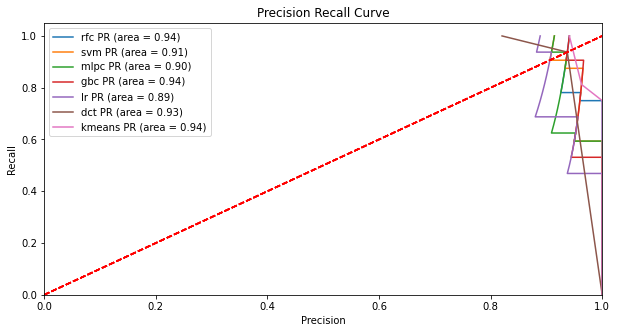

In [15]:
# Obtaining the accuracy scores without hyper parameter tuning
# Also plotting the precision recall curve. 
# The models are trained on 80% of the data, and the accuracy metrics are created on the other 20%.
acc1 = accuracy_scores(X, y)

In [16]:
acc1

,rfc,svm,mlpc,gbc,lr,dct,kmeans
Accuracy,0.948718,0.923077,0.871795,0.948718,0.897436,0.897436,0.948718
Precision,0.941176,0.914286,0.909091,0.941176,0.888889,0.937500,0.941176
Recall,1.000000,1.000000,0.937500,1.000000,1.000000,0.937500,1.000000
F1,0.969697,0.955224,0.923077,0.969697,0.941176,0.937500,0.969697
ROC AUC,0.857143,0.785714,0.754464,0.857143,0.714286,0.825893,0.857143
Kappa,0.804020,0.686327,0.539007,0.804020,0.551724,0.651786,0.804020


### Intial model results
Since a simple untuned decision tree with almost no features could make some accurate predictions, it should come to no suprise that more advanced models using all the features are also very accurate. Even without hyperparameter tuning.

Without any tuning and using default values the metrics of all the models are almost the same or in some cases are the same. <br>
There is probably a very large difference in the data for people with parkinson and for people without parkinson, making it very easy for all the models to predict <br>

The precision_recall curve shows the tradeoff of precion and recall accross various thresholds. No large differences are visible in the graph, the neligible changes could be attributed to how the thresholds are selected. <br>

In general it seems easy for all the models to obtain a (almost) perfect recall while keep having a high (0.80+) precision. The models only seem struggle a bit in maintaining a high recall when having a precision score of over 0.90

## 4. Hyper parameter tuning
This is kinda unnecessary as the models are already performing really well, but im doing it anyway to see if i can improve the models a little bit more. <br>
I am using randomizedsearchCV and the parameters that give the highest f1 score are returned. <br>
I use f1 score as opposed to accuracy because the dataset is slightly unbalanced. <br>

The initial parameter ranges for the models are chosen based on the param description in the documentation or in the case of the MLPC and GBC model based on information obtained from the internet.

In [17]:
# Raising an exception so that it stops here when i run all in the notebook
# I do this to prevent the hyperpara_check function from eating all my cores because i gave it n_jobs=-1
raise Exception('Jupyter run all blockade')

Exception: Jupyter run all blockade

In [18]:
# I tried different scoring metrics to calculate the hyper parameters, but none of them really make any difference.
kappa = metrics.make_scorer(metrics.cohen_kappa_score)

In [20]:
hyperpara_check(X, y, rfc_model(), iter_nr=400)

{'max_depth': 9,
 'max_features': 0.2819071593113428,
 'min_samples_leaf': 1,
 'min_samples_split': 0.01,
 'n_estimators': 110}

In [ ]:
hyperpara_check(X, y, gbc_model(), iter_nr=400)

{'learning_rate': 0.0505,
 'max_depth': 1,
 'max_features': 0.26691729658220065,
 'min_samples_leaf': 29,
 'min_samples_split': 0.13,
 'n_estimators': 60}

In [19]:
hyperpara_check(X, y, lr_model(), iter_nr=50)

c:\Users\rie12\anaconda3\envs\prog\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'solver': 'saga', 'C': 1.6733333333333336}

In [ ]:
hyperpara_check(X, y, kmeans_model())

{'p': 1, 'n_neighbors': 26, 'leaf_size': 22}

In [ ]:
hyperpara_check(X, y, svm_model())

{'kernel': 'linear', 'C': 2.297083333333333}

In [ ]:
hyperpara_check(X, y, mlpc_model())

{'hidden_layer_sizes': (100, 50, 100),
 'alpha': 0.0008890000000000001,
 'activation': 'relu'}

## 5. Creating the new models
Applying the obtained hyperparameters to models

In [23]:
def rfc_model2():
    params = {}
    model = RandomForestClassifier(max_depth = 25,
                                   max_features = 0.252,
                                   min_samples_leaf = 1,
                                   min_samples_split = 0.04,
                                   n_estimators = 210)
    return model, params


def gbc_model2():
    params = {}
    model = GradientBoostingClassifier(learning_rate= 0.07525,
                                       max_depth = 13,
                                       max_features = 0.26427,
                                       min_samples_leaf = 5,
                                       min_samples_split = 0.02,
                                       n_estimators = 210)
    return model, params

def lr_model2():
    params = {}
    model = LogisticRegression(solver = 'newton-cg', C = 0.564)
    return model, params

def svm_model2():
    params = {}
    model = SVC(probability=True, kernel = 'rbf', C = 3.544)
    return model, params

def mlpc_model2():
    params = {}
    model = MLPClassifier(hidden_layer_sizes= (50, 50, 100),
                          alpha= 0.000778,
                          activation= 'relu')
    return model, params

def kmeans_model2():
    params = {}
    model = KNeighborsClassifier(p = 1, n_neighbors = 1, leaf_size = 22)
    return model, params


c:\Users\rie12\anaconda3\envs\prog\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


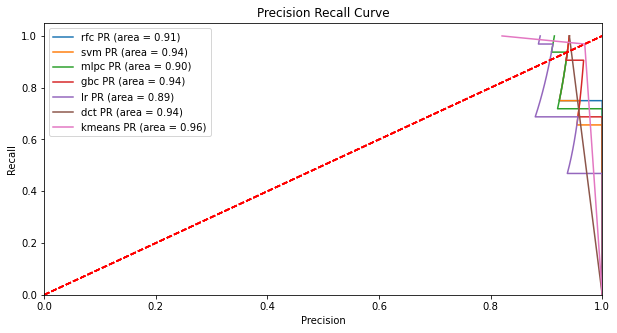

,rfc,svm,mlpc,gbc,lr,dct,kmeans
Accuracy,0.923077,0.948718,0.871795,0.948718,0.897436,0.948718,0.948718
Precision,0.914286,0.941176,0.909091,0.941176,0.888889,0.941176,0.968750
Recall,1.000000,1.000000,0.937500,1.000000,1.000000,1.000000,0.968750
F1,0.955224,0.969697,0.923077,0.969697,0.941176,0.969697,0.968750
ROC AUC,0.785714,0.857143,0.754464,0.857143,0.714286,0.857143,0.912946
Kappa,0.686327,0.804020,0.539007,0.804020,0.551724,0.804020,0.825893


In [24]:
# Obtaining the accuracy scores with the applied hyper parameter tuning
acc2 = accuracy_scores2(X, y)
acc2

In [25]:
# Seeing if the hyperparameter tuning actually produced any usefull results.
# And if any of the metrics have improved.
checkking  = pd.DataFrame(acc2) - pd.DataFrame(acc1)
checkking
# No metric improves by a lot, some even decrease 
# From this i can conclude that the 

,rfc,svm,mlpc,gbc,lr,dct,kmeans
Accuracy,-0.025641,0.025641,0.0,0.0,0.0,0.051282,0.000000
Precision,-0.026891,0.026891,0.0,0.0,0.0,0.003676,0.027574
Recall,0.000000,0.000000,0.0,0.0,0.0,0.062500,-0.031250
F1,-0.014473,0.014473,0.0,0.0,0.0,0.032197,-0.000947
ROC AUC,-0.071429,0.071429,0.0,0.0,0.0,0.031250,0.055804
Kappa,-0.117693,0.117693,0.0,0.0,0.0,0.152234,0.021873


### Different model validation techniques


In [ ]:
# Previously i used the holdout method for validating the models by training the model on %80 of the data and testing its performance on the other 20%.
# Here i will use k-fold validation to see if it makes a difference in f1 score.
# I will only apply this to the gbc model.
# https://www.researchgate.net/publication/346126028_Machine_Learning_Algorithm_Validation

kfold = KFold(n_splits=7, random_state=100, shuffle=True)
model, params = gbc_model2()
results_kfold = cross_val_score(model, X, y, cv=kfold, scoring='f1')
print("f1: %.3f%%" % (results_kfold.mean()*100.0)) 

f1: 95.631%


In [ ]:
# The % is the almost the exact same. 
# Meaning that for this dataset it does not matter which validation technique is used.
acc2['gbc']

Accuracy     0.948718
Precision    0.941176
Recall       1.000000
F1           0.969697
ROC AUC      0.857143
Kappa        0.804020
Name: gbc, dtype: float64

## 6. Results
It is clear that the models do not really improve even after the parameter tuning. (The results can change each iteration but never by much.) <br>
Most of the models are so close that difference is neglible, and they tend to get the same amount of false positives and negatives. (Recall usually 1 and precision ~0.94) <br>
Only the logistic regression model seems to be performing marginally worse, while the kmeans model seems to performing marginally better. <br>

Through all my iterations the highest accuracy i could achieve with my fixed train/test split was 0.948718, with the highest f1 score being 0.969697. <br>
While i could try and improve on this by using the stacked generalization ensamble method and combine some of models into 1, I believe that this will not achieve anything as all models have the same results, and adding them together will just create those same results again. <br>

I believe that the reason for high accuracy of all the models is because of the large difference in target classes. <br>
Meaning that if a person has parkingson they will not have a lot of overlap in data with a person that does not have parkinson. <br>
Making it easy for the models to distinquis between the classes <br>

I will try to confirm this by checking the differences between the features of the 4 most important features.

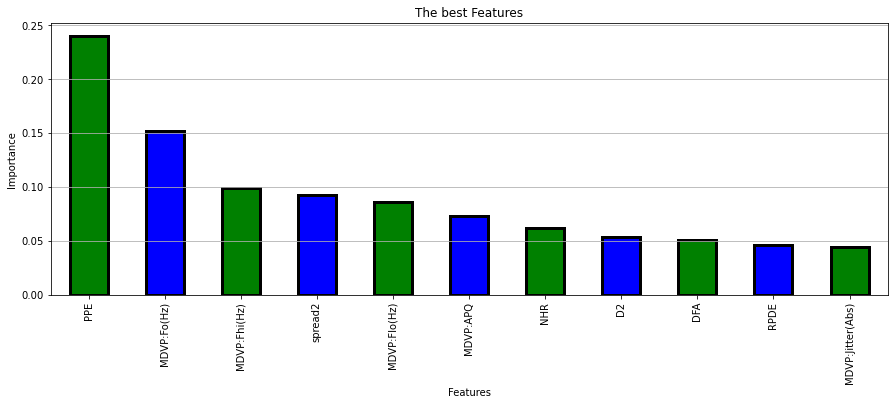

In [ ]:
# A plot of the best features of the gbc model created by sklearns feature importance.
feature_importance(X, y, gbc_model2())

In [ ]:
print(' Mean value differences between the 4 most important features:', '\n')
print(' Parkingson ppe: ', round(df1['PPE'].mean(), 3), '\n', 'No parkinson ppe: ', round(df0['PPE'].mean(), 3), '\n')
print(' Parkingson MDVP:Fo(Hz): ', round(df1['MDVP:Fo(Hz)'].mean(), 3), '\n', 'No parkinson MDVP:Fo(Hz): ', round(df0['MDVP:Fo(Hz)'].mean(), 3), '\n')
print(' Parkingson MDVP:Fhi(Hz): ', round(df1['MDVP:Fhi(Hz)'].mean(), 3), '\n', 'No parkinson MDVP:Fhi(Hz): ', round(df0['MDVP:Fhi(Hz)'].mean(), 3), '\n')
print(' Parkingson spread2: ', round(df1['spread2'].mean(), 3), '\n', 'No parkinson spread2: ', round(df0['spread2'].mean(), 3), '\n')

 Mean value differences between the 4 most important features: 

 Parkingson ppe:  0.234 
 No parkinson ppe:  0.123 

 Parkingson MDVP:Fo(Hz):  145.181 
 No parkinson MDVP:Fo(Hz):  181.938 

 Parkingson MDVP:Fhi(Hz):  188.441 
 No parkinson MDVP:Fhi(Hz):  223.637 

 Parkingson spread2:  0.248 
 No parkinson spread2:  0.16 



The differences do seem quite large. Which would confirm my initial beliefs

# Genome data
Before i tried the parkinson data, i tried the second data source but while i managed to generate the data using discoal. It was impossible for me to figure out what do with the output next.
Neither the research paper nor the discoal documentation gave any info :(
<br>
I have included a small copy of the output called discoal_output.txt <br>
The actual output was 16X larger <br> <br>
My question is: What was i supposed to do with it, and did anyone else succeed in this?

In [ ]:
li = []
with open('discoal_output.txt') as file:
    for line in file:
        li.append(line)
#print(li)

# <h1><b><span style="color:blue">FIN</span></b></h1>